In [6]:
require('rstan')
require('ggplot2')
require('tidyverse')
require('reshape2')


Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.2     ✔ purrr   0.2.4
✔ tidyr   0.8.1     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.3.0
✔ tibble  1.4.2     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::extract() masks rstan::extract()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



## Model 1 Results

In [1]:
biomarker <- read.table("../phe_extraction/list_biomarker.txt", header=TRUE, stringsAsFactors=FALSE)

In [2]:
biomarker$name

[1] "Alanine aminotransferase"   "Albumin "                  
 [3] "Alkaline phosphatase"       "Apolipoprotein A"          
 [5] "Apolipoprotein B"           "Aspartate aminotransferase"
 [7] "C-reactive protein"         "Calcium "                  
 [9] "Cholesterol "               "Creatinine "               
[11] "Cystatin C"                 "Direct bilirubin"          
[13] "Gamma glutamyltransferase"  "Glucose "                  
[15] "Glycated haemoglobin"       "HDL cholesterol"           
[17] "IGF-1 "                     "LDL direct"                
[19] "Lipoprotein A"              "Oestradiol "               
[21] "Phosphate "                 "Rheumatoid factor"         
[23] "SHBG "                      "Testosterone "             
[25] "Total bilirubin"            "Total protein"             
[27] "Triglycerides "             "Urate "                    
[29] "Urea "                      "Vitamin D"

In [3]:
# check which failed

list.traits <- biomarker$Field
exists <- sapply(list.traits, function(trait) file.exists(sprintf("../data/biomarker/summary_dat_%s_2_.txt",trait)))
list.traits[!exists]  # which failed - check+re-run?

list.traits2 <- list.traits[exists]

[1] 30840

In [7]:
# load all the summary data
trait.df <- do.call(rbind, lapply(list.traits2, function(trait) {df <- read.delim2(sprintf("../data/biomarker/summary_dat_%s_2_.txt",trait), sep=" ", stringsAsFactors=FALSE); return(df)
                                                               }))
colnames(trait.df) <-c("trait", "N", "pi[1]", "pi[2]", "Sigma[1,1]", "Sigma[1,2]", "Sigma[2,1]", "Sigma[2,2]", 
  "rg", "rg.l", "rg.u", "hf", "hm")
trait.df2 <- inner_join(trait.df, biomarker, by=c("trait"="Field"))
trait.df2 <- trait.df2 %>% select(trait, name, everything())

In [8]:
# convert to numeric
trait.df3 <- cbind(trait.df2[,1:2], data.frame(apply(trait.df2[,3:ncol(trait.df2)], c(1,2), as.numeric)))
trait.df3$name <- as.factor(trait.df3$name)
head(trait.df3)


trait,name,N,pi.1.,pi.2.,Sigma.1.1.,Sigma.1.2.,Sigma.2.1.,Sigma.2.2.,rg,rg.l,rg.u,hf,hm
30620,Alanine aminotransferase,329746,0.8947739,0.105226063,7.172421e-05,6.960079e-05,6.960079e-05,7.873114e-05,0.9262760,0.9077810,0.9433732,NA,NA
30600,Albumin,329257,0.9081278,0.091872193,9.482733e-05,9.336865e-05,9.336865e-05,9.498615e-05,0.9838577,0.9696727,0.9964139,0.1278487,0.1375049
30610,Alkaline phosphatase,330011,0.9730553,0.026944659,6.440879e-04,7.865322e-04,7.865322e-04,9.831660e-04,0.9884096,0.9854120,0.9912018,0.1218310,0.1594359
30630,Apolipoprotein A,329094,0.9582231,0.041776899,3.451655e-04,3.526252e-04,3.526252e-04,3.808396e-04,0.9726059,0.9654149,0.9790811,0.1216364,0.1351325
30640,Apolipoprotein B,329722,0.9919588,0.008041158,2.344222e-03,2.028669e-03,2.028669e-03,1.809115e-03,0.9851004,0.9816250,0.9880179,0.1419184,0.1100582
30650,Aspartate aminotransferase,329840,0.9447765,0.055223532,1.763835e-04,1.821286e-04,1.821286e-04,1.973887e-04,0.9761190,0.9672101,0.9849759,NA,NA


In [9]:
missing_traits <- filter(trait.df3, is.na(hf) | is.na(hm))$trait
missing_traits 
# TODO - check these converge - why are they missing heritability?

[1] 30620 30650 30820 30830

#### Plot genetic correlation

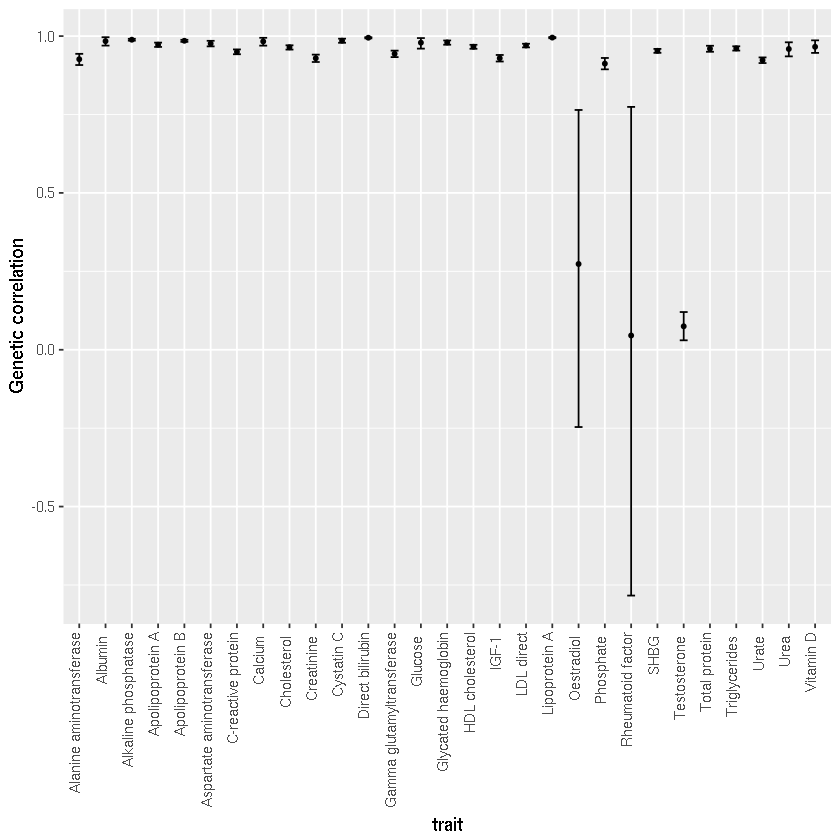

In [10]:
ggplot(trait.df3, aes(x=name, y=rg))+geom_errorbar(aes(ymin=rg.l, ymax=rg.u), width=0.3)+geom_point(size=1)+
xlab("trait")+ylab("Genetic correlation")+ theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.1))

#### Plot heritability

In [68]:
herit_df <- do.call(rbind, lapply(c(1:3,5), function(x) 
    read.delim(sprintf("../data/biomarker/herit/errorBars_%s.txt", x), sep=" ", header=FALSE)))

In [69]:
colnames(herit_df) <- c("trait", "int", "sex", "value")
head(herit_df)
# add in the other herit vals

trait,int,sex,value
30620,up,hf,NA
30620,low,hf,NA
30620,up,hm,NA
30620,low,hm,NA
30600,up,hf,0.1408093
30600,low,hf,0.1216826


In [70]:
herit_val <- trait.df3[,c("trait", "name", "hf", "hm")]
herit_long <-melt(herit_val, id.vars = c("trait", "name"), variable.name="sex")
herit_long$int <- "center"
herit_w_int <- rbind(herit_long %>% select(colnames(herit_df)), herit_df)

herit_w_int2 <- left_join(herit_w_int, biomarker, by=c("trait"="Field"))
head(herit_w_int2)


trait,int,sex,value,name
30620,center,hf,NA,Alanine aminotransferase
30600,center,hf,0.1278487,Albumin
30610,center,hf,0.1218310,Alkaline phosphatase
30630,center,hf,0.1216364,Apolipoprotein A
30640,center,hf,0.1419184,Apolipoprotein B
30650,center,hf,NA,Aspartate aminotransferase


In [71]:
herit_w_int3 <- filter(herit_w_int2, !is.na(value))
herit_w_int3$name <- factor(herit_w_int3$name)
herit_w_int3$sex <- factor(herit_w_int3$sex)
herit_w_int3$int <- factor(herit_w_int3$int)

herit_w_int3$value <- sapply(herit_w_int3$value, function(x) unlist(as.numeric(as.character(x))))
head(herit_w_int3)
herit_w_int3 <- herit_w_int3[!duplicated(herit_w_int3), ]
herit_w_int4 <- dcast(herit_w_int3, trait+sex+name ~ int, value.var="value")
head(herit_w_int4)

trait,int,sex,value,name
30600,center,hf,0.1278487,Albumin
30610,center,hf,0.1218310,Alkaline phosphatase
30630,center,hf,0.1216364,Apolipoprotein A
30640,center,hf,0.1419184,Apolipoprotein B
30710,center,hf,0.1434291,C-reactive protein
30680,center,hf,0.1107175,Calcium


trait,sex,name,center,low,up
30600,hf,Albumin,0.1278487,0.1216826,0.1408093
30600,hm,Albumin,0.1375049,0.1298560,0.1452704
30610,hf,Alkaline phosphatase,0.1218310,0.1152558,0.1341012
30610,hm,Alkaline phosphatase,0.1594359,0.1504074,0.1734482
30630,hf,Apolipoprotein A,0.1216364,0.1147522,0.1332554
30630,hm,Apolipoprotein A,0.1351325,0.1294135,0.1458449


Warning message:
“Removed 6 rows containing missing values (geom_errorbar).”

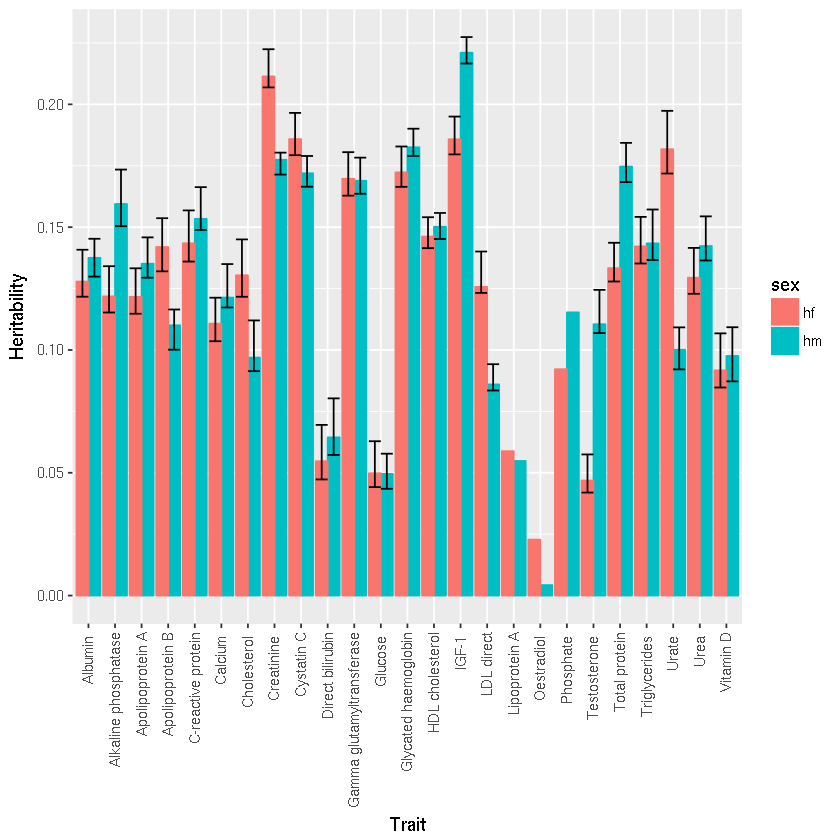

In [72]:

ggplot(herit_w_int4, aes(x=name, y=center, fill=sex, color=sex))+geom_bar(stat="identity", 
           position=position_dodge())+geom_errorbar(aes(ymin=low, ymax=up), position=position_dodge(), color="black") +
theme(axis.text.x=element_text(angle=90, hjust=1, vjust=0.45)) +ylab("Heritability")+xlab("Trait")


## Model 2 Results

In [ ]:
# check convergence?

In [73]:
list.traits <- biomarker$Field
f.exists<- sapply(list.traits, function(trait) file.exists(sprintf("../data/biomarker/m2/f_spec_%s.txt",trait)))
m.exists<- sapply(list.traits, function(trait) file.exists(sprintf("../data/biomarker/m2/m_spec_%s.txt",trait)))


In [71]:
list.traits <- biomarker$Field
m2exists <- sapply(list.traits, function(trait) file.exists(sprintf("../data/biomarker/m2/snp_table_%s.txt",trait)))
list.traits[!m2exists]  # which failed - none - interesting...

integer(0)

In [78]:
f_comb_list <- lapply(list.traits[f.exists], function(trait){
snp_table <- read.table(sprintf("../data/biomarker/m2/f_spec_%s.txt",trait), header=TRUE, stringsAsFactors=FALSE); 
    if(nrow(snp_table)==0){return(NA)};
    snp_table$"trait" <- trait; return(snp_table)}
    )
f_tab <- do.call(rbind, f_comb_list[!is.na(f_comb_list)])
f_tab <- left_join(f_tab, biomarker, by=c("trait"="Field"))

m_comb_list <- lapply(list.traits[m.exists], function(trait){
snp_table <- read.table(sprintf("../data/biomarker/m2/m_spec_%s.txt",trait), header=TRUE, stringsAsFactors=FALSE); 
    if(nrow(snp_table)==0){return(NA)};
    snp_table$"trait" <- trait; return(snp_table)}
    )
m_tab <- do.call(rbind, m_comb_list[!is.na(m_comb_list)])
m_tab <- left_join(m_tab, biomarker, by=c("trait"="Field"))


In [81]:

f_tab
m_tab

SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,post,gene,trait,name
rs121918002,1,21900176,-2.356940,-2.3781700,0.12276300,0.1425590,2.01763e-62,4.73793e-82,1.0000000,ALPL,30610,Alkaline phosphatase
Affx-52354612,15,58838103,0.600455,0.4826170,0.08639650,0.0819930,3.96392e-09,3.66964e-12,0.8922078,LIPC,30630,Apolipoprotein A
Affx-89019160,10,101157378,-2.612300,-2.4551100,0.08356950,0.0839547,1.87359e-187,8.39583e-214,1.0000000,GOT1,30650,Aspartate aminotransferase
rs146049867,10,101165952,-0.649511,-0.4771150,0.06137670,0.0623815,2.04807e-14,3.67569e-26,0.9999985,GOT1,30650,Aspartate aminotransferase
rs8177505,6,160679656,0.503970,0.4787960,0.04915880,0.0511723,8.34833e-21,1.18291e-24,0.9995797,SLC22A2,30700,Creatinine
Affx-92045743,20,23615951,-3.231980,-3.3988100,0.12873200,0.1471420,8.18308e-118,8.93569e-139,1.0000000,CST3,30720,Cystatin C
rs201226914,16,88798919,-0.509970,-0.5053440,0.04555500,0.0466535,2.48975e-27,4.45154e-29,0.6544744,PIEZO1,30750,Glycated haemoglobin
Affx-52354612,15,58838103,0.640991,0.4537770,0.08492860,0.0819133,3.03517e-08,4.46767e-14,0.9993879,LIPC,30760,HDL cholesterol
rs150090666,11,14865399,0.527802,0.2718830,0.05953800,0.0574659,2.23413e-06,7.74324e-19,0.9997144,PDE3B,30760,HDL cholesterol
rs188308962,9,107620797,-0.540755,-0.3952150,0.04691610,0.0487080,4.93934e-16,1.00853e-30,0.9124556,ABCA1,30760,HDL cholesterol


SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,post,gene,trait,name
rs145331563,8,145729793,-1.235340,-1.230680,0.1027240,0.0969291,6.44686e-37,2.69515e-33,0.9998864,GPT,30620,Alanine aminotransferase
Affx-80210950,1,21890636,-1.704370,-2.071740,0.1238570,0.1321980,2.62459e-55,4.66418e-43,1.0000000,ALPL,30610,Alkaline phosphatase
Affx-80210956,1,21902399,-2.290080,-2.846240,0.1656090,0.1764130,1.65233e-58,1.83314e-43,1.0000000,ALPL,30610,Alkaline phosphatase
Affx-80274606,6,24448140,-0.673791,-0.996988,0.0713672,0.0759264,2.30139e-39,3.73642e-21,1.0000000,GPLD1,30610,Alkaline phosphatase
rs121918007,1,21890632,-1.402300,-1.526630,0.0654705,0.0695106,9.70757e-107,1.27174e-101,0.9999981,ALPL,30610,Alkaline phosphatase
rs121918019,1,21890587,-1.717640,-1.922750,0.0975893,0.0978328,6.94022e-86,2.86179e-69,1.0000000,ALPL,30610,Alkaline phosphatase
rs140895057,6,24460508,0.764542,0.832437,0.1586470,0.1523120,4.62731e-08,1.44320e-06,0.8432105,GPLD1,30610,Alkaline phosphatase
rs149093201,6,24450108,-0.592748,-0.803574,0.0657168,0.0711659,1.48517e-29,1.90718e-19,0.9999957,GPLD1,30610,Alkaline phosphatase
rs62400471,6,24472814,-0.690685,-0.694121,0.1260760,0.1300260,9.39399e-08,4.30055e-08,0.4819054,GPLD1,30610,Alkaline phosphatase
rs118204057,8,19811733,-0.559850,-0.908756,0.0898801,0.0830811,7.77408e-28,4.71254e-10,1.0000000,LPL,30630,Apolipoprotein A


In [81]:
#extractSNPtab <- function(trait){
source("../mixture_model_scripts/snp_utils.R")

#}

[1] "30830"

     1      3      4 
328169      1   1044 
[1] 2
[1] 329882     11


In [82]:
f.tab
m.tab

[1] ""

SNP,CHR,BP,B_f,B_m,SE_f,SE_m,p_m,p_f,post,gene
rs137853336,20,43042354,-0.972246,-1.13674,0.150167,0.130534,3.11661e-18,9.5489e-11,1,HNF4A


In [78]:
# ones that are m/f
names(tab_counts) <- list.traits
tab_counts[sapply(tab_counts, function(x) "2" %in% names(x) | "3" %in% names(x))]
    

$`30620`

     1      3      4 
329306      1    439 

$`30610`

     1      2      3      4 
328431      1      8   1571 

$`30630`

     1      2      3      4 
328003      1      2   1088 

$`30650`

     1      2      4 
328835      2   1003 

$`30700`

     1      2      3      4 
327958      1      3   1787 

$`30720`

     1      2      3      4 
329109      1      1   1461 

$`30750`

     1      2      3      4 
328405      1      4   1856 

$`30760`

     1      2      3      4 
327839      4      2   1281 

$`30800`

     1      2 
308529      1 

$`30810`

     1      2      3      4 
328750      1      1    361 

$`30830`

     1      3      4 
328169      1   1044 

$`30850`

     1      2      3      4 
328382    100    469     24 

$`30870`

     1      2      3      4 
328524      2      3   1340 

$`30880`

     1      3      4 
328923      2    938 


## OLD ANALYSIS

In [3]:
load("../data/biomarker/f_30690.RData")

[1] "dat"  "fit1"

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00076 0.00000 0.00003 0.00071 0.00076 0.00082   728 1.00324
Sigma[1,2]    0.00063 0.00000 0.00002 0.00059 0.00063 0.00068   710 1.00259
Sigma[2,1]    0.00063 0.00000 0.00002 0.00059 0.00063 0.00068   710 1.00259
Sigma[2,2]    0.00056 0.00000 0.00002 0.00052 0.00056 0.00060   746 1.00293
pi[1]         0.98361 0.00002 0.00058 0.98246 0.98360 0.98474   820 1.00637
pi[2]         0.01639 0.00002 0.00058 0.01526 0.01640 0.01754   820 1.00637
Omegacor[1,1] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.96460 0.00012 0.00350 0.95720 0.96468 0.97130   894 1.00106
Omegacor[2,1] 0.96460 0.00012 0.00350 0.95720 0.96468 0.97130   894 1.00106
Omegacor[2,2] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN

Samp

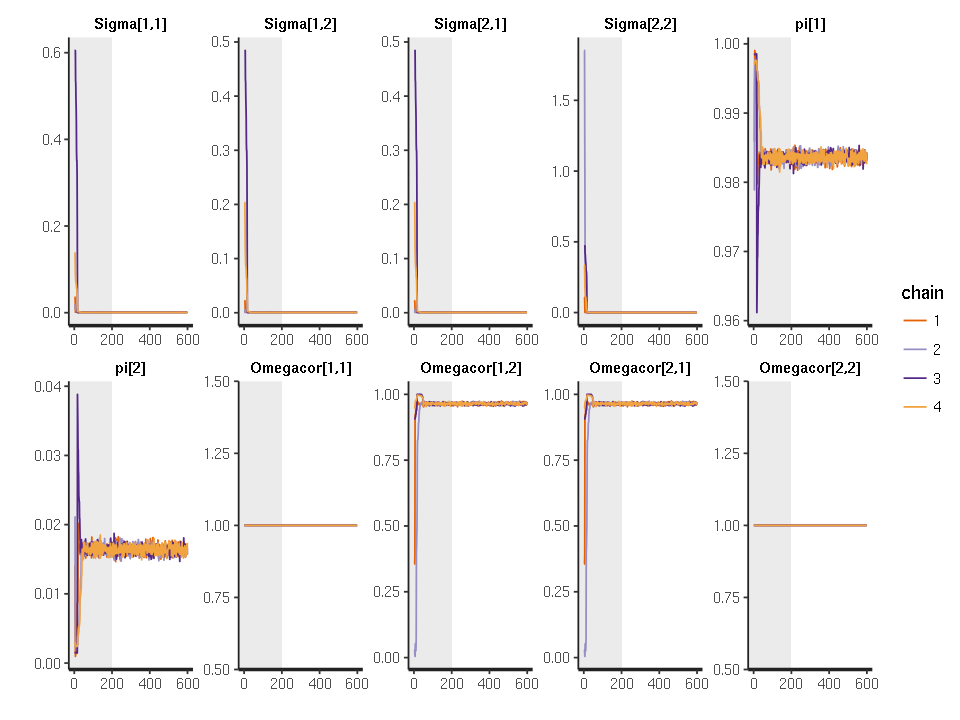

In [4]:
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)


In [11]:
sum_tab <- read.delim2("../data/biomarker/summary_dat_30690_2_.txt", sep=" ", stringsAsFactors=FALSE)
m1.pi <- sum_tab[,3:4]
m1.Sigma <- sum_tab[,5:8]
m1.rg <- sum_tab[,9]
ml.rg.l <- sum_tab[,10]
ml.rg.u <- sum_tab[,11]
hf <- sum_tab[,12]
hm <- sum_tab[,13]
#(c(trait, dat$dat$N, unlist(m1.pi), unlist(m1.Sigma), unlist(rg), unlist(rg.c$l), unlist(rg.c$u), unlist(h)))


Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00028   0e+00 0.00002 0.00025 0.00028 0.00031   787 0.99961
Sigma[1,2]    0.00003   0e+00 0.00001 0.00001 0.00003 0.00005  1175 1.00065
Sigma[2,1]    0.00003   0e+00 0.00001 0.00001 0.00003 0.00005  1175 1.00065
Sigma[2,2]    0.00060   0e+00 0.00003 0.00054 0.00059 0.00066   674 1.00381
pi[1]         0.98419   4e-05 0.00094 0.98230 0.98421 0.98600   665 1.00069
pi[2]         0.01581   4e-05 0.00094 0.01400 0.01579 0.01770   665 1.00069
Omegacor[1,1] 1.00000   0e+00 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.07379   7e-04 0.02386 0.03002 0.07303 0.12178  1174 1.00100
Omegacor[2,1] 0.07379   7e-04 0.02386 0.03002 0.07303 0.12178  1174 1.00100
Omegacor[2,2] 1.00000   0e+00 0.00000 1.00000 1.00000 1.00000  1524 0.99750

Samp

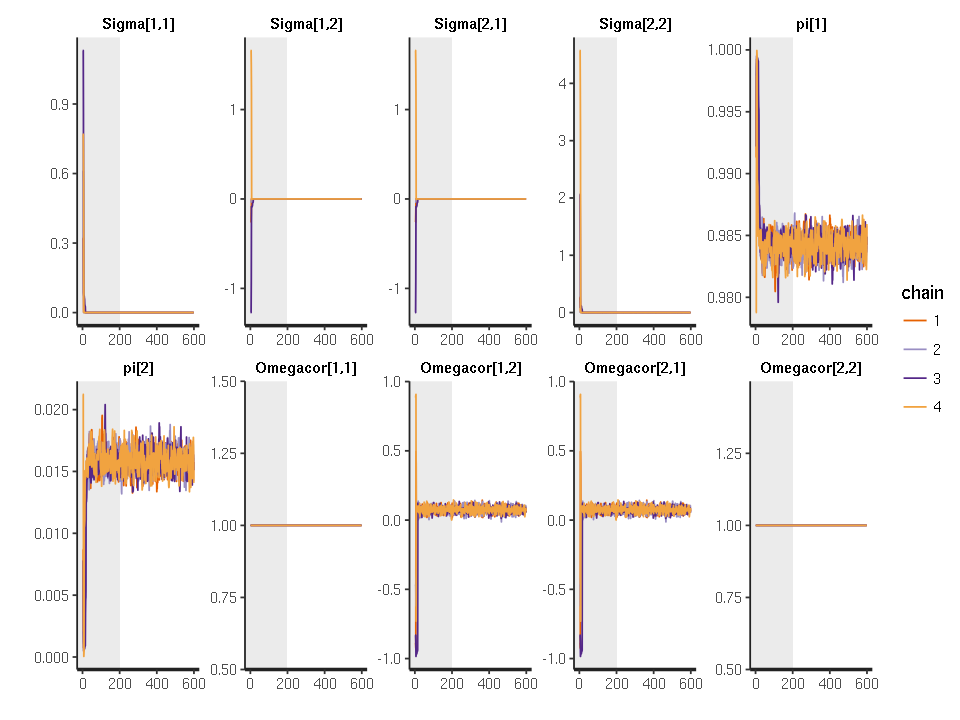

In [12]:
load("../data/biomarker/f_30850.RData")
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)

Inference for Stan model: model1_no_loglik.
4 chains, each with iter=600; warmup=200; thin=1; 
post-warmup draws per chain=400, total post-warmup draws=1600.

                 mean se_mean      sd    2.5%     50%   97.5% n_eff    Rhat
Sigma[1,1]    0.00016 0.00000 0.00000 0.00016 0.00016 0.00017   925 1.00096
Sigma[1,2]    0.00017 0.00000 0.00000 0.00017 0.00017 0.00018   850 1.00073
Sigma[2,1]    0.00017 0.00000 0.00000 0.00017 0.00017 0.00018   850 1.00073
Sigma[2,2]    0.00019 0.00000 0.00000 0.00018 0.00019 0.00020   874 1.00069
pi[1]         0.91793 0.00006 0.00178 0.91445 0.91790 0.92143   816 1.00053
pi[2]         0.08207 0.00006 0.00178 0.07857 0.08210 0.08555   816 1.00053
Omegacor[1,1] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN
Omegacor[1,2] 0.97953 0.00011 0.00335 0.97262 0.97962 0.98554  1006 1.00043
Omegacor[2,1] 0.97953 0.00011 0.00335 0.97262 0.97962 0.98554  1006 1.00043
Omegacor[2,2] 1.00000 0.00000 0.00000 1.00000 1.00000 1.00000  1600     NaN

Samp

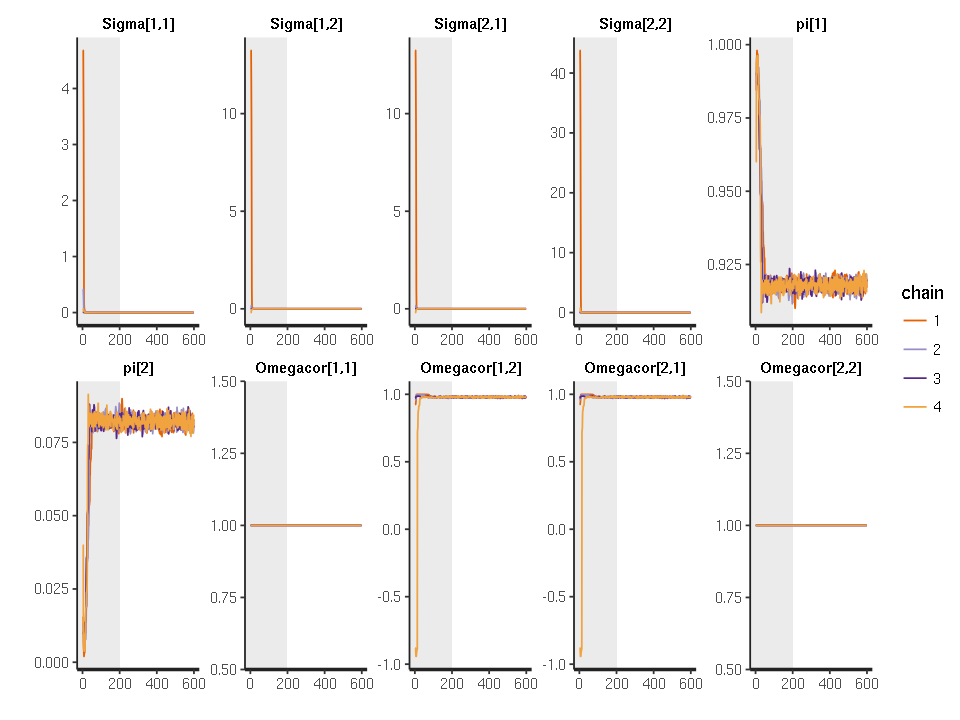

In [13]:
load("../data/biomarker/f_30750.RData")
print(fit1, pars=c("Sigma", "pi", "Omegacor"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1, pars = c("Sigma", "pi", "Omegacor"), inc_warmup = TRUE, nrow = 2)

In [27]:
list.traits <- c("30850", "30750", "30690")
trait.names <- c("testosterone", "hba1c", "cholesterol")
trait.df <- do.call(rbind, lapply(list.traits, function(trait) {df <- read.delim2(sprintf("../data/biomarker/summary_dat_%s_2_.txt",trait), sep=" ", stringsAsFactors=FALSE); return(df)
                                                               }))
colnames(trait.df) <-c("trait", "N", "pi[1]", "pi[2]", "Sigma[1,1]", "Sigma[1,2]", "Sigma[2,1]", "Sigma[2,2]", 
  "rg", "rg.l", "rg.u", "hf", "hm")
trait.df <- data.frame(apply(trait.df, c(1,2), as.numeric))
trait.df$names <- trait.names


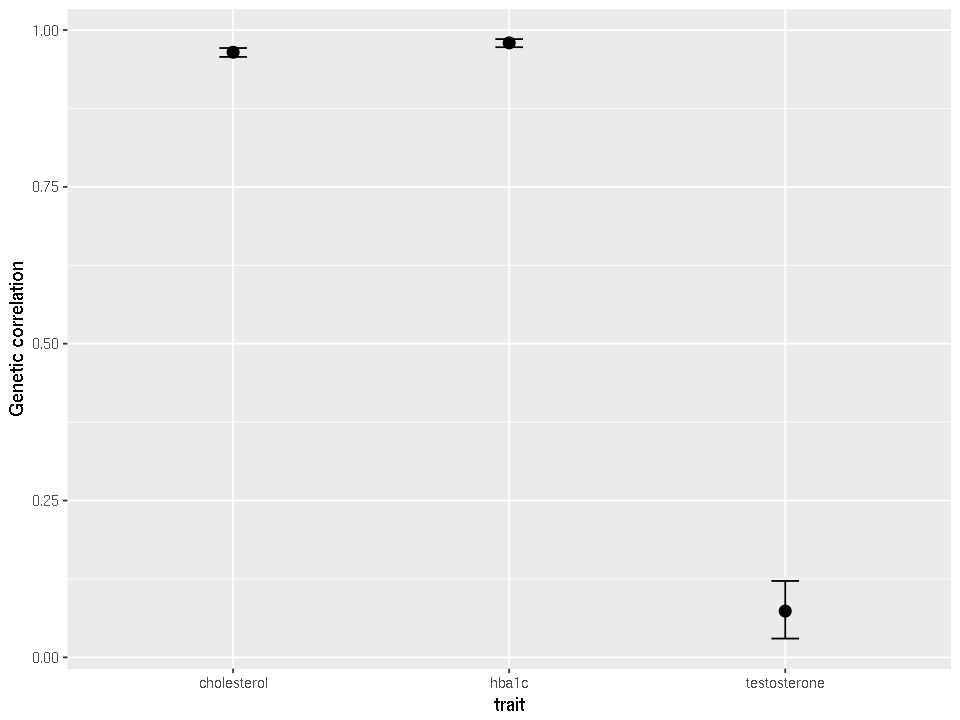

In [47]:
ggplot(trait.df, aes(x=names, y=rg))+geom_errorbar(aes(ymin=rg.l, ymax=rg.u), width=0.1)+geom_point(size=3)+
xlab("trait")+ylab("Genetic correlation")


  

In [36]:
melted_herit <- melt(trait.df[,c("names", "hf", "hm")])

Using names as id variables


names,variable,value
testosterone,hf,0.04674465
hba1c,hf,0.17223152
cholesterol,hf,0.13052704
testosterone,hm,0.11052843
hba1c,hm,0.18259033
cholesterol,hm,0.09703021


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”

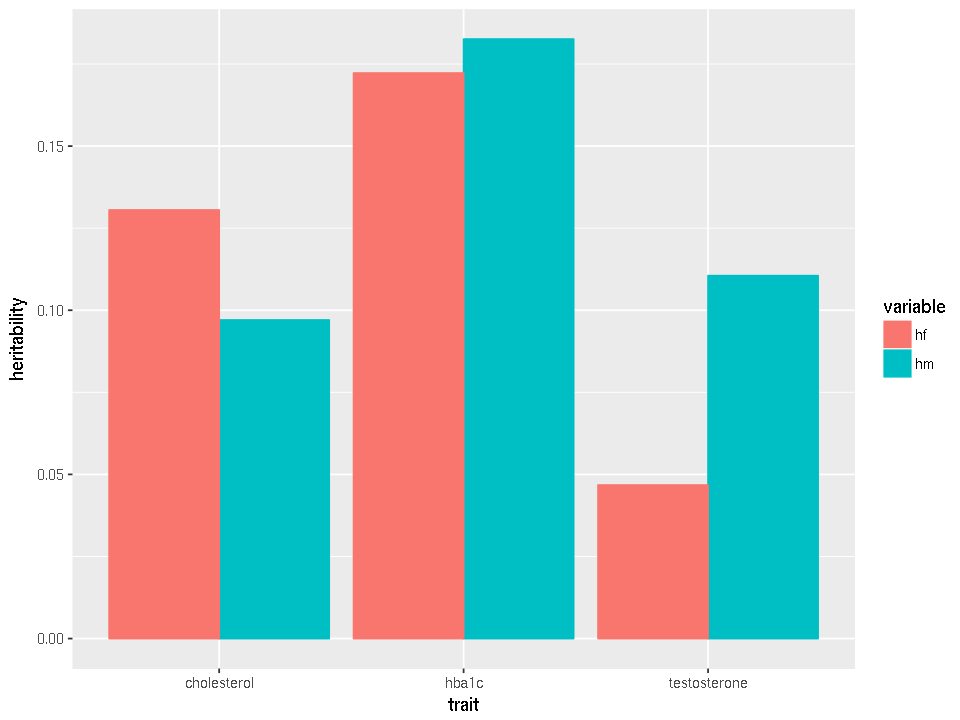

In [48]:
melted_herit
ggplot(melted_herit, aes(x=names, y=value, colour=variable, fill=variable))+geom_histogram(stat="identity", position="dodge")+
xlab("trait")+ylab("heritability")